<a href="https://www.kaggle.com/toutatsu/roberta-test?scriptVersionId=89256712" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
#defaul libraries
#https://docs.python.org/ja/
import os
import math
import random
import pprint
import time
import typing
import json
import glob
import warnings
import gc

import numpy as np #https://numpy.org/
import pandas as pd #https://pandas.pydata.org/
import sklearn #https://scikit-learn.org/stable/

import matplotlib.pyplot as plt #https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.html
%matplotlib inline
from tqdm import tqdm #https://tqdm.github.io/

import torch #https://pytorch.org/
import transformers #https://huggingface.co/transformers/

In [2]:
#https://www.kaggle.com/getting-started/140636

import torch
from numba import cuda

# !pip install GPUtil
# from GPUtil import showUtilization as gpu_usage

def free_gpu_cache():
#     print("Initial GPU Usage")
#     gpu_usage()                             

    torch.cuda.empty_cache()

#     cuda.select_device(0)
#     cuda.close()
#     cuda.select_device(0)

#     print("GPU Usage after emptying the cache")
#     gpu_usage()

#free_gpu_cache()

In [3]:
class CFG():
    
    input_path="../input/commonlitreadabilityprize"
    debug=False
    seed=3

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    batch_size=16
    epochs=10
    learning_rate=2e-5
    kFold=5

    #高速化関連
    #https://qiita.com/sugulu_Ogawa_ISID/items/62f5f7adee083d96a587

    #GPU 遅くなるらしい↓
    torch.backends.cudnn.deterministic = True

    #イテレーションごとのnnの順伝搬および誤差関数の 計算手法がある程度一定であれば、torch.backends.cudnn.benchmark = Trueで GPU での計算が高速化
    torch.backends.cudnn.benchmark = False


def set_seed(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    #tf.random.set_seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(CFG.seed)

In [4]:
def color(string,fg='DEFAULT',bg='DEFAULT',fg_rgb=None,bg_rgb=None,style='END'):
    colors=['BLACK','RED','GREEN','YELLOW','BLUE','PURPLE','CYAN','WHITE','8','DEFAULT']
    styles=['END','BOLD','2','3','UNDERLINE','5','6','REVERSE','INVISIBLE','9']

    fg=f'\033[3{colors.index(fg)}m'
    bg=f'\033[4{colors.index(bg)}m'
    style=f'\033[0{styles.index(style)}m'

    if fg_rgb:fg=f"\033[38;2;{fg_rgb[0]};{fg_rgb[1]};{fg_rgb[2]}m"
    if bg_rgb:bg=f"\033[48;2;{bg_rgb[0]};{bg_rgb[1]};{bg_rgb[2]}m"

    return style+fg+bg+str(string)+'\033[0m'

In [5]:
train=pd.read_csv(os.path.join(CFG.input_path,"train.csv"),index_col='id',usecols=['id','excerpt', 'target'])
test=pd.read_csv(os.path.join(CFG.input_path,"test.csv"),index_col='id',usecols=['id','excerpt'])
sample_submission=pd.read_csv(os.path.join(CFG.input_path,"sample_submission.csv"),index_col='id')

if CFG.debug:train=train[:len(train)//30]

test['target']=0

df=pd.concat([train,test])

In [6]:
df

,excerpt,target
id,,
c12129c31,When the young people returned to the ballroom...,-0.340259
85aa80a4c,"All through dinner time, Mrs. Fayre was somewh...",-0.315372
b69ac6792,"As Roger had predicted, the snow departed as q...",-0.580118
dd1000b26,And outside before the palace a great garden w...,-1.054013
37c1b32fb,Once upon a time there were Three Bears who li...,0.247197
...,...,...
0df072751,It was a bright and cheerful scene that greete...,0.000000
04caf4e0c,Cell division is the process by which a parent...,0.000000
0e63f8bea,Debugging is the process of finding and resolv...,0.000000


In [7]:
tokenizer=transformers.RobertaTokenizer.from_pretrained("../input/clrp-roberta-base/clrp_roberta_base")

In [8]:
df['token_len']=df.excerpt.apply(tokenizer.encode).apply(len)
#df['token_len_']=df.excerpt.str.split().apply(len)

max_len=max(df['token_len'])
max_len

322

In [9]:
train=df[:len(train)].copy()
test=df[len(train):].copy()

In [10]:
train

,excerpt,target,token_len
id,,,
c12129c31,When the young people returned to the ballroom...,-0.340259,227
85aa80a4c,"All through dinner time, Mrs. Fayre was somewh...",-0.315372,238
b69ac6792,"As Roger had predicted, the snow departed as q...",-0.580118,225
dd1000b26,And outside before the palace a great garden w...,-1.054013,224
37c1b32fb,Once upon a time there were Three Bears who li...,0.247197,186
...,...,...,...
25ca8f498,When you think of dinosaurs and where they liv...,1.711390,184
2c26db523,So what is a solid? Solids are usually hard be...,0.189476,192
cd19e2350,The second state of matter we will discuss is ...,0.255209,222


In [11]:
test

,excerpt,target,token_len
id,,,
c0f722661,My hope lay in Jack's promise that he would ke...,0.0,174
f0953f0a5,Dotty continued to go to Mrs. Gray's every nig...,0.0,236
0df072751,It was a bright and cheerful scene that greete...,0.0,235
04caf4e0c,Cell division is the process by which a parent...,0.0,231
0e63f8bea,Debugging is the process of finding and resolv...,0.0,220
12537fe78,"To explain transitivity, let us look first at ...",0.0,187
965e592c0,Milka and John are playing in the garden. Her ...,0.0,195


In [12]:
class CommonLit_DataSet(torch.utils.data.Dataset):
    def __init__(self,sentences,targets):
        self.sentences=sentences
        self.targets=targets

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self,idx):
        
        enc=tokenizer(
            self.sentences[idx].replace('\n', ''),
            add_special_tokens=True,
            return_attention_mask=True,
            padding='max_length',
            max_length=max_len,
        )
        return {
            'ids':torch.tensor(enc['input_ids'],dtype=torch.long),
            'mask':torch.tensor(enc['attention_mask'],dtype=torch.long),
            #'token_type_ids':torch.tensor(enc['token_type_ids'],dtype=torch.long),
            'targets':torch.tensor(self.targets[idx],dtype=torch.float)
        }

In [13]:
class RMSELoss(torch.nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.mse = torch.nn.MSELoss()
        self.eps = eps
        
    def forward(self,yhat,y):
        loss = torch.sqrt(self.mse(yhat,y) + self.eps)
        return loss
    
loss_fun=RMSELoss()

In [14]:
#とりあえず学習できるように
def train_val_test(model,dataloader,phase,optimizer=None,scheduler=None,scaler=None):# モデルを学習させる関数
    
    #assert((phase=='train')==bool(optimizer))#学習時にoptimizer必須
    
    model.train() if phase=='train' else model.eval()   # モデルのモード
    model.to(CFG.device)
    
    preds=[]
    losses=[]
    
    # データローダーからミニバッチを取り出すループ
    for enc in dataloader[phase]:
        
        # optimizerを初期化
        if phase=='train':optimizer.zero_grad()
       
        # 順伝搬（forward）計算
        with torch.set_grad_enabled(phase=='train'):
            
            # non_blocking=TrueでPinned MemoryからGPUに転送中もCPUが動作できるらしい。
            ids = enc["ids"].to(CFG.device,non_blocking=True) 
            mask = enc["mask"].to(CFG.device,non_blocking=True)
            
            with torch.cuda.amp.autocast():
                outputs = model(ids,mask)["logits"].squeeze(-1)

                if phase!='test':
                    loss_val = loss_fun(outputs, enc["targets"].to(CFG.device,non_blocking=True))  # 損失を計算
                    losses.append(loss_val.item())

                    # 訓練時はバックプロパゲーション
                    if phase == 'train':
    #                     loss_val.backward()
    #                     optimizer.step()
                        scaler.scale(loss_val).backward() # ロスのバックワード
                        scaler.step(optimizer) # オプティマイザーの更新
                        scaler.update() # スケーラーの更新
                    
                        scheduler.step() # 学習率の更新 ここに入れるべき？　まだ使わない

        preds.extend(outputs.detach().cpu().numpy())

#         del ids,mask#####,outputs
#         if phase!='test':del loss_val
#         torch.cuda.empty_cache()
        gc.collect()
    
    #if phase!='test':return preds,np.mean(losses)
    return preds

In [15]:
#https://www.kaggle.com/chumajin/bert-v-s-roberta-english

from sklearn.model_selection import KFold
from transformers import get_linear_schedule_with_warmup


def initialize(seed,fold):
    
    set_seed(seed)
    
    kf=KFold(n_splits=CFG.kFold,shuffle=True,random_state=CFG.seed)
    train_index, valid_index = list(kf.split(train))[fold]

    dataset={
        'train':CommonLit_DataSet(train.iloc[train_index].excerpt, train.iloc[train_index].target),
        'valid':CommonLit_DataSet(train.iloc[valid_index].excerpt, train.iloc[valid_index].target),
        'test':CommonLit_DataSet(test.excerpt,test.target),
    }
    
    dataloader={
        'train':
        torch.utils.data.DataLoader(
            dataset['train'],
            batch_size=CFG.batch_size,
            shuffle=True,
            num_workers=2,#os.cpu_count(),
            pin_memory=True
        ),
        'valid':
        torch.utils.data.DataLoader(
            dataset['valid'],
            batch_size=CFG.batch_size,
            shuffle=False,
            num_workers=2,#os.cpu_count(),
            pin_memory=True
        ),
        'test':
        torch.utils.data.DataLoader(
            dataset['test'],
            batch_size=CFG.batch_size,
            shuffle=False,
            num_workers=2,#os.cpu_count(),
            pin_memory=True
        )
    }
    
    model = transformers.RobertaForSequenceClassification.from_pretrained("../input/clrp-roberta-base/clrp_roberta_base",num_labels=1)
    optimizer = transformers.AdamW(model.parameters(), CFG.learning_rate,betas=(0.9, 0.999), weight_decay=1e-2) # AdamW optimizer
    
    train_steps = int(len(train)/CFG.batch_size*CFG.epochs)
    scheduler = get_linear_schedule_with_warmup(optimizer, int(train_steps*0.1), train_steps)
    
    scaler = torch.cuda.amp.GradScaler() # GPUでの高速化。
    
    return dataset,dataloader,model,optimizer,scheduler,scaler
    

In [16]:
def cross_validation():

    for fold in range(CFG.kFold):
        print('fold',fold)
        losses={
            'train':[],
            'valid':[]
        }
    
        dataset,dataloader,model,optimizer,scheduler,scaler=initialize(CFG.seed,fold)
        bestscore=100

        for epoch in range(CFG.epochs):
            print("epoch=",epoch)

            preds=train_val_test(model,dataloader,'train',optimizer,scheduler,scaler)
            plt.scatter(dataset['train'].targets,preds,color='blue',s=5)
            
            loss=np.sqrt(sklearn.metrics.mean_squared_error(preds,list(dataset['train'].targets)))
            print(color("train",bg="BLUE",style='BOLD')+':'+color(f"{loss}","BLUE"))
            losses['train'].append(loss)

            preds=train_val_test(model,dataloader,'valid')
            plt.scatter(dataset['valid'].targets,preds,color='red',s=5)
            
            
            loss=np.sqrt(sklearn.metrics.mean_squared_error(preds,list(dataset['valid'].targets)))
            print(color("val  ",bg="RED",style='BOLD')+':'+color(f"{loss}","RED"))
            losses['valid'].append(loss)
            
            if bestscore > loss:
                bestscore = loss
                print(color("BEST SCORE",bg='YELLOW')+' :',color(bestscore,'YELLOW'))
                
                torch.save(
                    {
                        'state_dict': model.state_dict(),
                        'optimizer_dict': optimizer.state_dict(),
                        'bestscore':bestscore,
                        'seed':CFG.seed
                    },
                    "Roberta_fold"+str(fold)+".pth"
                )
            #print(preds)
            
            plt.plot([i/10 for i in range(-40,20,1)],[i/10 for i in range(-40,20,1)],linestyle='dashed',color='green')
            plt.show()
            
        plt.plot(losses['train'],color='blue')
        plt.plot(losses['valid'],color='red')
        plt.show()

fold 0


Some weights of the model checkpoint at ../input/clrp-roberta-base/clrp_roberta_base were not used when initializing RobertaForSequenceClassification: ['lm_head.decoder.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ../input/clrp-roberta-base/clrp_roberta_base and are newly initialized: ['classifi

epoch= 0
train:1.192693349311001
val  :0.6614842156905892
BEST SCORE : 0.6614842156905892


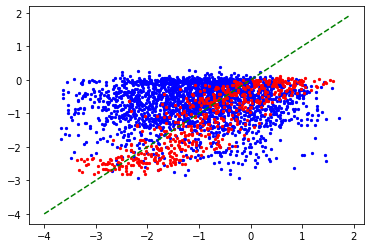

epoch= 1
train:1.312082992616074
val  :0.5109928118642463
BEST SCORE : 0.5109928118642463


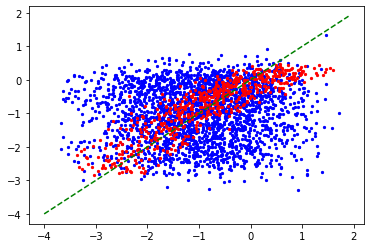

epoch= 2
train:1.357576206790844
val  :0.5494915378420581


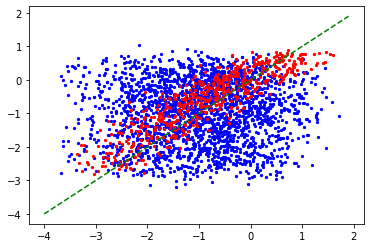

epoch= 3
train:1.3915307960321646
val  :0.6701726896271044


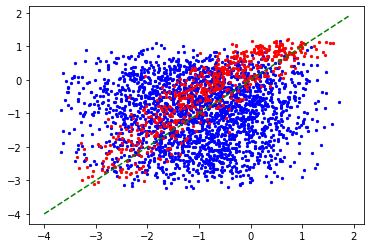

epoch= 4
train:1.4008911498434116
val  :0.5827133644610013


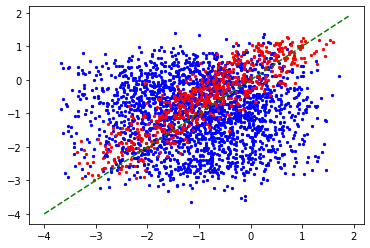

epoch= 5
train:1.4347576179171233
val  :0.5990259006596685


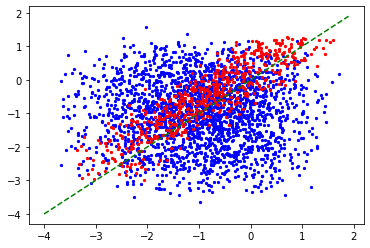

epoch= 6
train:1.435424210441507
val  :0.5833002471832769


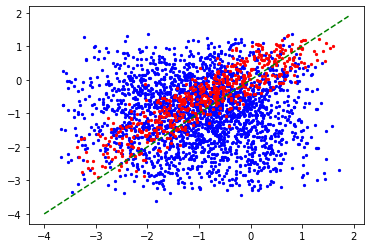

epoch= 7
train:1.4312895897267488
val  :0.5899597446102897


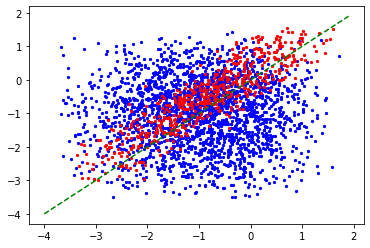

epoch= 8
train:1.4551645756205116
val  :0.5552737097370407


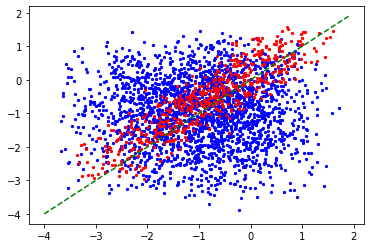

epoch= 9
train:1.4405062011118164
val  :0.5309561164410382


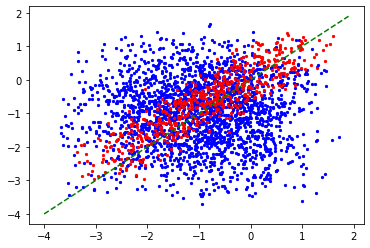

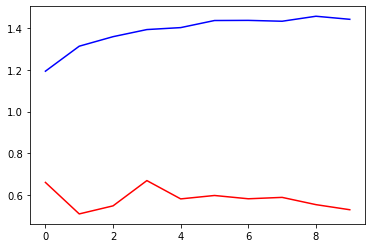

fold 1


Some weights of the model checkpoint at ../input/clrp-roberta-base/clrp_roberta_base were not used when initializing RobertaForSequenceClassification: ['lm_head.decoder.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ../input/clrp-roberta-base/clrp_roberta_base and are newly initialized: ['classifi

epoch= 0
train:1.23744254862187
val  :0.573007969515696
BEST SCORE : 0.573007969515696


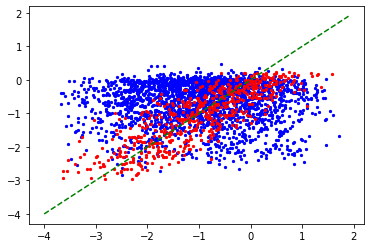

epoch= 1
train:1.3671371886235575
val  :0.5478266622928128
BEST SCORE : 0.5478266622928128


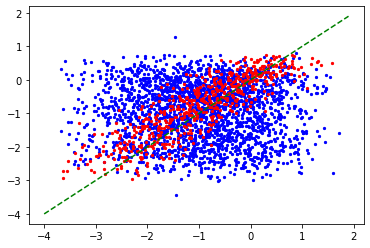

epoch= 2
train:1.3988620164063357
val  :0.6481879058347991


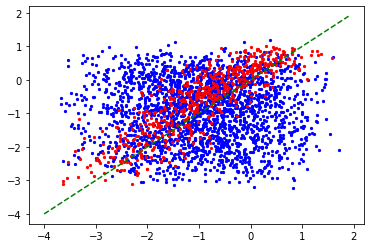

epoch= 3
train:1.408981096906583
val  :0.640118847174331


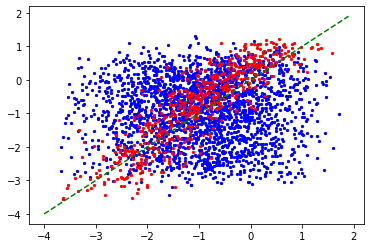

epoch= 4
train:1.4743227263338354
val  :0.7145584824361791


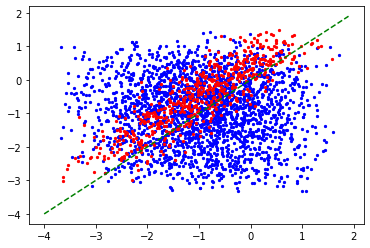

epoch= 5
train:1.459526414150186
val  :0.5760715002386074


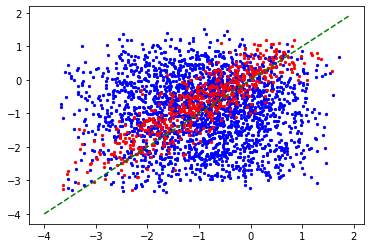

epoch= 6
train:1.4629080481796637
val  :0.6073914871866049


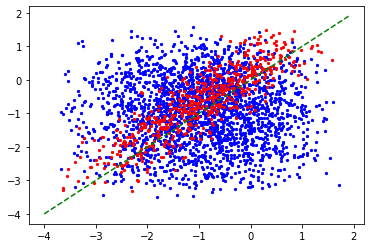

epoch= 7
train:1.4569005994848516
val  :0.6630202093316049


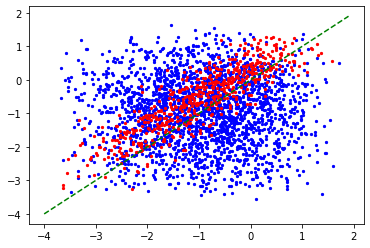

epoch= 8
train:1.4334184608982325
val  :0.616269041636656


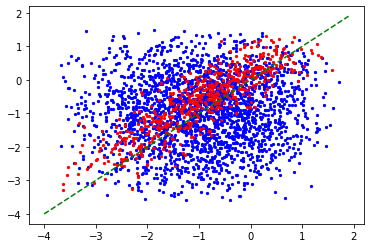

epoch= 9
train:1.464164752329839
val  :0.6417972162604669


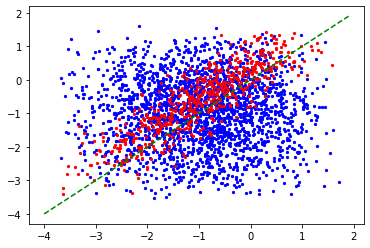

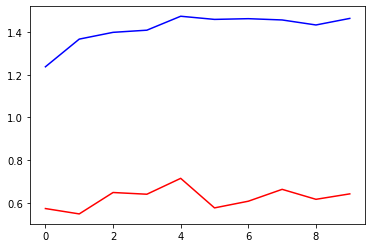

fold 2


Some weights of the model checkpoint at ../input/clrp-roberta-base/clrp_roberta_base were not used when initializing RobertaForSequenceClassification: ['lm_head.decoder.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ../input/clrp-roberta-base/clrp_roberta_base and are newly initialized: ['classifi

epoch= 0
train:1.2262989682878986
val  :0.6417310227723116
BEST SCORE : 0.6417310227723116


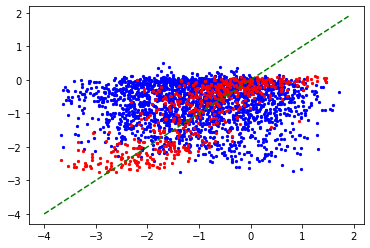

epoch= 1
train:1.337668919197602
val  :0.5697887061420245
BEST SCORE : 0.5697887061420245


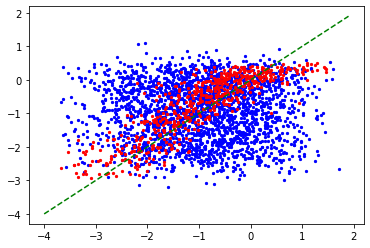

epoch= 2
train:1.397438455849003
val  :0.515309803877816
BEST SCORE : 0.515309803877816


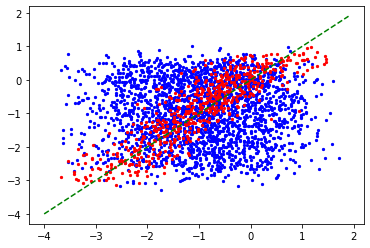

epoch= 3
train:1.4091396599258867
val  :0.6846754938433538


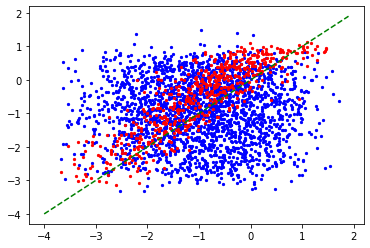

epoch= 4
train:1.4208340293343704
val  :0.6716175156537908


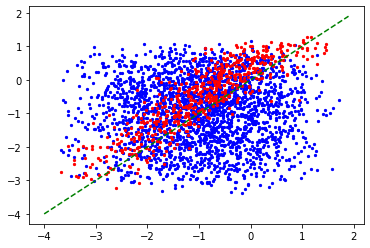

epoch= 5
train:1.4177890183820272
val  :0.6279931047040613


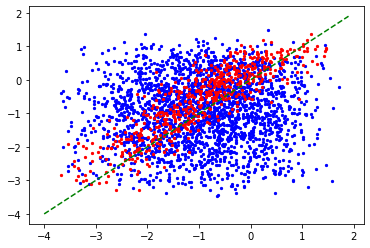

epoch= 6
train:1.4683978296594677
val  :0.6236869616316408


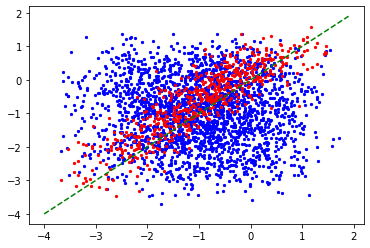

epoch= 7
train:1.4558060016518208
val  :0.6299096236601902


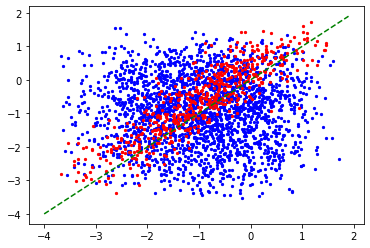

epoch= 8
train:1.452600955967581
val  :0.6494747213818565


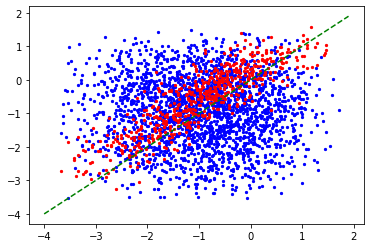

epoch= 9
train:1.45557395512584
val  :0.5610989696609344


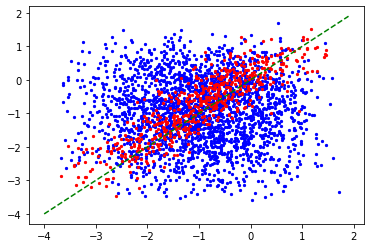

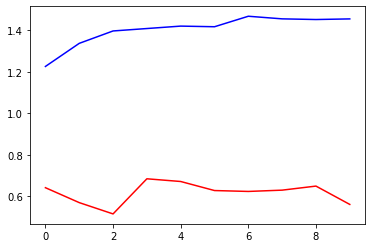

fold 3


Some weights of the model checkpoint at ../input/clrp-roberta-base/clrp_roberta_base were not used when initializing RobertaForSequenceClassification: ['lm_head.decoder.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ../input/clrp-roberta-base/clrp_roberta_base and are newly initialized: ['classifi

epoch= 0
train:1.224540366079986
val  :0.5952546972671646
BEST SCORE : 0.5952546972671646


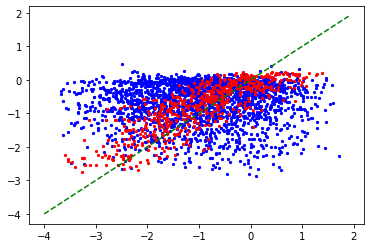

epoch= 1
train:1.3700331287588148
val  :0.6315638128550359


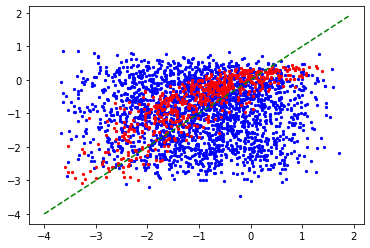

epoch= 2
train:1.4014315615580784
val  :0.5158324758706612
BEST SCORE : 0.5158324758706612


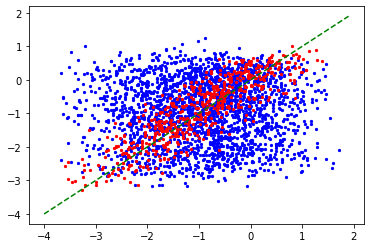

epoch= 3
train:1.454849191598421
val  :0.6586993819188125


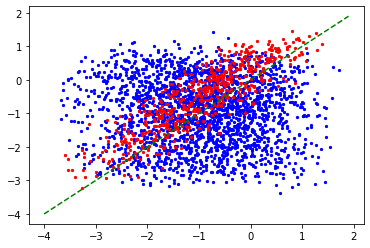

epoch= 4
train:1.4299605013877088
val  :0.6454713071386586


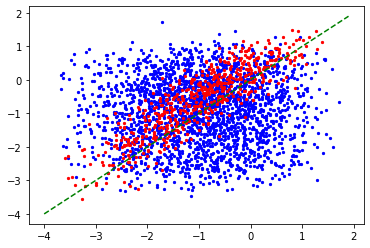

epoch= 5
train:1.4425030353750927
val  :0.6332121570610594


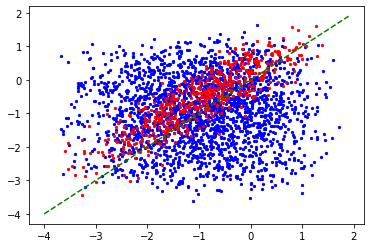

epoch= 6
train:1.4838713269339947
val  :0.6047969945618779


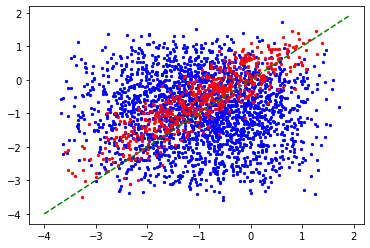

epoch= 7
train:1.4403040128342675
val  :0.6795466659547063


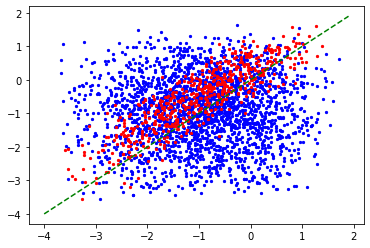

epoch= 8
train:1.4433971701547874
val  :0.592558927902091


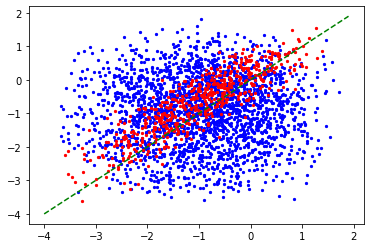

epoch= 9
train:1.4643497467996096
val  :0.6162453654349794


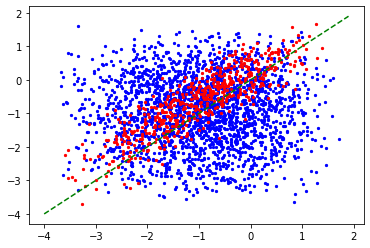

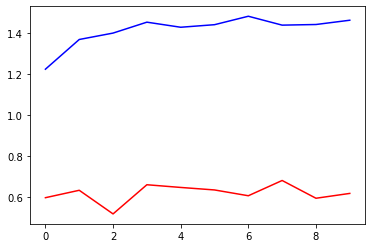

fold 4


Some weights of the model checkpoint at ../input/clrp-roberta-base/clrp_roberta_base were not used when initializing RobertaForSequenceClassification: ['lm_head.decoder.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ../input/clrp-roberta-base/clrp_roberta_base and are newly initialized: ['classifi

epoch= 0
train:1.1915767702090978
val  :0.6067349719202136
BEST SCORE : 0.6067349719202136


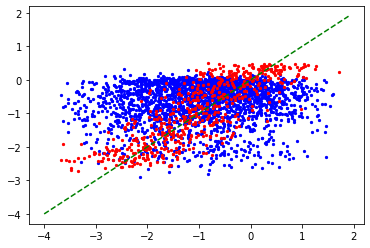

epoch= 1
train:1.3534348389646826
val  :0.5467990362322894
BEST SCORE : 0.5467990362322894


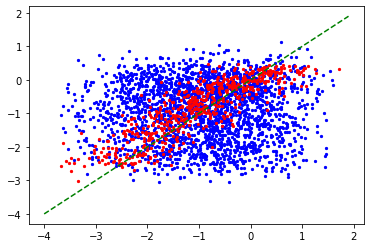

epoch= 2
train:1.4065498139531256
val  :0.565835196486192


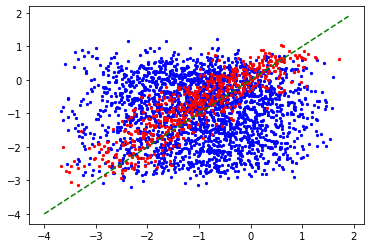

epoch= 3
train:1.4451693828054855
val  :0.7346389187558835


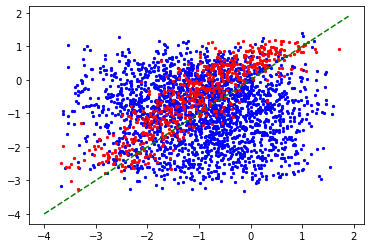

epoch= 4
train:1.399205362333941
val  :0.6219646616770884


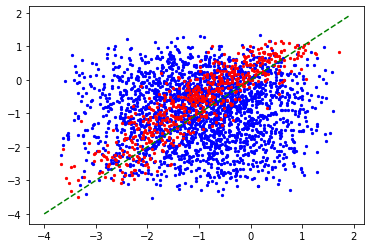

epoch= 5
train:1.4305984193481405
val  :0.689785384136566


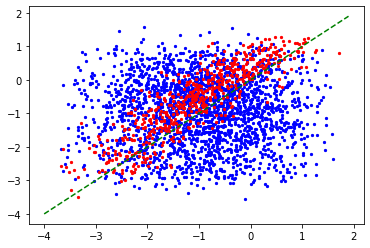

epoch= 6
train:1.4579259872538746
val  :0.5992403624268805


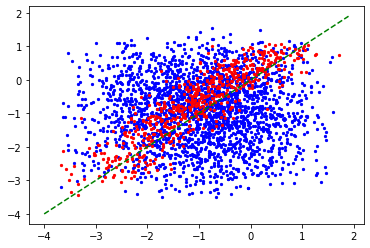

epoch= 7
train:1.446909776797096
val  :0.634844410755848


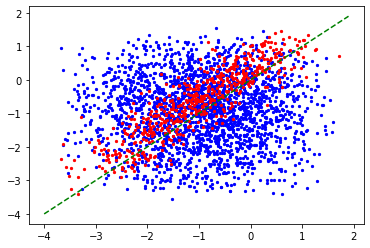

epoch= 8
train:1.422375466472502
val  :0.6439753780040521


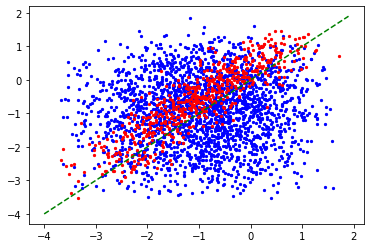

epoch= 9
train:1.4605640203775703
val  :0.6352961589649762


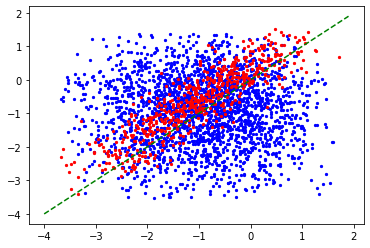

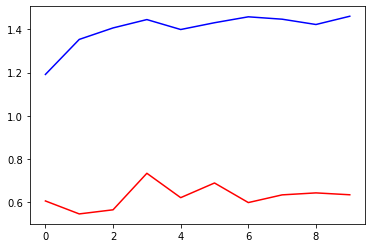

CPU times: user 1h 39min 33s, sys: 59.3 s, total: 1h 40min 32s
Wall time: 1h 41min 30s


In [17]:
%%time
cross_validation()

In [18]:
best_models=["Roberta_fold0.pth","Roberta_fold1.pth","Roberta_fold2.pth","Roberta_fold3.pth","Roberta_fold4.pth"]

preds=pd.DataFrame(columns=best_models)
preds['id']=test.index
preds=preds.set_index('id')

preds

for pth in best_models:
    
    
    model = transformers.RobertaForSequenceClassification.from_pretrained("../input/clrp-roberta-base/clrp_roberta_base",num_labels=1)
    model.load_state_dict(torch.load(pth)["state_dict"])
    
    score=torch.load(pth)["bestscore"]
    
#     if score>0.54:
#         preds.drop(pth, axis=1)
#         continue
        
    print(score)

    
    dataloader={'test':torch.utils.data.DataLoader(
            CommonLit_DataSet(test.excerpt,test.target),
            batch_size=CFG.batch_size,
            shuffle=False,
            num_workers=2,#os.cpu_count(),
            pin_memory=True
    )}
    
    preds[pth]=train_val_test(model,dataloader,'test')

Some weights of the model checkpoint at ../input/clrp-roberta-base/clrp_roberta_base were not used when initializing RobertaForSequenceClassification: ['lm_head.decoder.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ../input/clrp-roberta-base/clrp_roberta_base and are newly initialized: ['classifi

0.5109928118642463


Some weights of the model checkpoint at ../input/clrp-roberta-base/clrp_roberta_base were not used when initializing RobertaForSequenceClassification: ['lm_head.decoder.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ../input/clrp-roberta-base/clrp_roberta_base and are newly initialized: ['classifi

0.5478266622928128


Some weights of the model checkpoint at ../input/clrp-roberta-base/clrp_roberta_base were not used when initializing RobertaForSequenceClassification: ['lm_head.decoder.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ../input/clrp-roberta-base/clrp_roberta_base and are newly initialized: ['classifi

0.515309803877816


Some weights of the model checkpoint at ../input/clrp-roberta-base/clrp_roberta_base were not used when initializing RobertaForSequenceClassification: ['lm_head.decoder.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ../input/clrp-roberta-base/clrp_roberta_base and are newly initialized: ['classifi

0.5158324758706612


Some weights of the model checkpoint at ../input/clrp-roberta-base/clrp_roberta_base were not used when initializing RobertaForSequenceClassification: ['lm_head.decoder.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ../input/clrp-roberta-base/clrp_roberta_base and are newly initialized: ['classifi

0.5467990362322894


In [19]:
preds

,Roberta_fold0.pth,Roberta_fold1.pth,Roberta_fold2.pth,Roberta_fold3.pth,Roberta_fold4.pth
id,,,,,
c0f722661,-0.458740,-0.279053,-0.135010,-0.261230,-0.453857
f0953f0a5,-0.363525,-0.097961,-0.310547,-0.210938,-0.444580
0df072751,-0.247192,-0.100098,-0.248779,-0.069214,-0.318604
04caf4e0c,-2.724609,-2.337891,-2.494141,-2.781250,-2.525391
0e63f8bea,-1.365234,-1.751953,-1.743164,-1.970703,-1.320312
12537fe78,-1.014648,-0.993164,-1.255859,-1.591797,-0.832520
965e592c0,0.212036,0.467041,0.437256,0.299072,0.241821


In [20]:
submission=pd.DataFrame(columns=['target'])
submission['id']=test.index
submission=submission.set_index('id')
submission.target=preds.mean(axis=1)
submission

,target
id,
c0f722661,-0.317578
f0953f0a5,-0.285510
0df072751,-0.196777
04caf4e0c,-2.572656
0e63f8bea,-1.630273
12537fe78,-1.137598
965e592c0,0.331445


In [21]:
submission.to_csv("submission.csv",index=id)